# Probabilistic Programming in Python using PyMC

Authors: John Salvatier, Thomas V. Wiecki, Christopher Fonnesbeck

## Introduction

Probabilistic programming (PP) allows flexible specification of Bayesian statistical models in code. PyMC3 is a new, open-source PP framework with an intutive and readable, yet powerful, syntax that is close to the natural syntax statisticians use to describe models. It features next-generation Markov chain Monte Carlo (MCMC) sampling algorithms such as the No-U-Turn Sampler (NUTS; Hoffman, 2014), a self-tuning variant of Hamiltonian Monte Carlo (HMC; Duane, 1987). This class of samplers works well on high dimensional and complex posterior distributions and allows many complex models to be fit without specialized knowledge about fitting algorithms. HMC and NUTS take advantage of gradient information from the likelihood to achieve much faster convergence than traditional sampling methods, especially for larger models. NUTS also has several self-tuning strategies for adaptively setting the tunable parameters of Hamiltonian Monte Carlo, whicstatisticalh means you usually don't need to have specialized knowledge about how the algorithms work. PyMC3, Stan (Stan Development Team, 2014), and the LaplacesDemon package for R are currently the only PP packages to offer HMC.

Probabilistic programming in Python confers a number of advantages including multi-platform compatibility, an expressive yet clean and readable syntax, easy integration with other scientific libraries, and extensibility via C, C++, Fortran or Cython. These features make it relatively straightforward to write and use custom statistical distributions, samplers and transformation functions, as required by Bayesian analysis.

While most of PyMC3's user-facing features are written in pure Python, it leverages Theano (Bergstra et al., 2010) to transparently transcode models to C and compile them to machine code, thereby boosting performance. Theano is a library that allows expressions to be defined using generalized vector data structures called *tensors*, which are tightly integrated with the popular NumPy `ndarray` data structure, and similarly allow for broadcasting and advanced indexing, just as NumPy arrays do. Theano also automatically optimizes the likelihood's computational graph for speed and provides simple GPU integration.

Here, we present a primer on the use of PyMC3 for solving general Bayesian statistical inference and prediction problems. We will first see the basics of how to use PyMC3, motivated by a simple example: installation, data creation, model definition, model fitting and posterior analysis. Then we will cover two case studies and use them to show how to define and fit more sophisticated models. Finally we will show how to extend PyMC3 and discuss other useful features: the Generalized Linear Models subpackage, custom distributions, custom transformations and alternative storage backends.

## Installation

Running PyMC3 requires a working Python interpreter, either version 2.7 (or more recent) or 3.4 (or more recent); we recommend that new users install version 3.4. A complete Python installation for Mac OSX, Linux and Windows can most easily be obtained by downloading and installing the free [`Anaconda Python Distribution`](https://store.continuum.io/cshop/anaconda/) by ContinuumIO. 

`PyMC3` can be installed using `pip` (https://pip.pypa.io/en/latest/installing.html):

```
pip install git+https://github.com/pymc-devs/pymc3
```

PyMC3 depends on several third-party Python packages which will be automatically installed when installing via pip. The four required dependencies are: `Theano`, `NumPy`, `SciPy`, and `Matplotlib`. 

To take full advantage of PyMC3, the optional dependencies `Pandas` and `Patsy` should also be installed. These are *not* automatically installed, but can be installed by:

```
pip install patsy pandas
```

The source code for PyMC3 is hosted on GitHub at https://github.com/pymc-devs/pymc3 and is distributed under the liberal [Apache License 2.0](https://github.com/pymc-devs/pymc3/blob/master/LICENSE). On the GitHub site, users may also report bugs and other issues, as well as contribute code to the project, which we actively encourage.

## A Motivating Example: Linear Regression

To introduce model definition, fitting and posterior analysis, we first consider a simple Bayesian linear regression model with normal priors for the parameters. We are interested in predicting outcomes $Y$ as normally-distributed observations with an expected value $\mu$ that is a linear function of two predictor variables, $X_1$ and $X_2$.

$$\begin{aligned} 
Y  &\sim \mathcal{N}(\mu, \sigma^2) \\
\mu &= \alpha + \beta_1 X_1 + \beta_2 X_2
\end{aligned}$$

where $\alpha$ is the intercept, and $\beta_i$ is the coefficient for covariate $X_i$, while $\sigma$ represents the observation error. Since we are constructing a Bayesian model, the unknown variables in the model must be assigned a prior distribution. We choose zero-mean normal priors with variance of 100 for both regression coefficients, which corresponds to *weak* information regarding the true parameter values. We choose a half-normal distribution (normal distribution bounded at zero) as the prior for $\sigma$.

$$\begin{aligned} 
\alpha &\sim \mathcal{N}(0, 100) \\
\beta_i &\sim \mathcal{N}(0, 100) \\
\sigma &\sim \lvert\mathcal{N}(0, 1){\rvert}
\end{aligned}$$

###Generating data

We can simulate some artificial data from this model using only NumPy's `random` module, and then use PyMC3 to try to recover the corresponding parameters. We are intentionally generating the data to closely correspond the PyMC3 model structure.

In [1]:
import numpy as np
import pylab as pl

# Intialize random number generator
np.random.seed(123)

# True parameter values
alpha, sigma = 1, 1
beta = [1, 2.5]

# Size of dataset
size = 100

# Predictor variable
X1 = np.linspace(0, 1, size)
X2 = np.linspace(0,.2, size)

# Simulate outcome variable
Y = alpha + beta[0]*X1 + beta[1]*X2 + np.random.randn(size)*sigma

Here is what the simulated data look like. We use the `pylab` module from the plotting library matplotlib. 

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


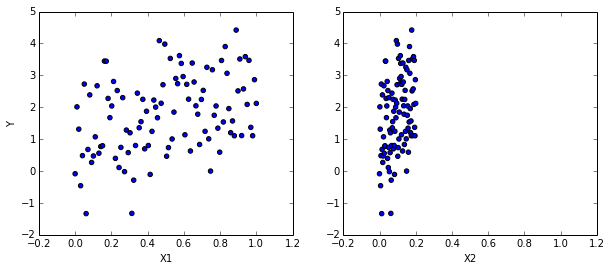

In [2]:
%pylab inline 

fig, axes = subplots(1, 2, sharex=True, figsize=(10,4))
axes[0].scatter(X1, Y)
axes[1].scatter(X2, Y)
axes[0].set_ylabel('Y'); axes[0].set_xlabel('X1'); axes[1].set_xlabel('X2');

###Model Specification

Specifiying this model in PyMC3 is straightforward because the syntax is as close to the statistical notation. For the most part, each line of Python code corresponds to a line in the model notation above. 

First, we import the components we will need from PyMC.

In [3]:
from pymc3 import Model, Normal, HalfNormal

Now we build our model, which we will present in full first, then explain each part line-by-line.

In [4]:
basic_model = Model()

with basic_model:
    
    # Priors for unknown model parameters
    alpha = Normal('alpha', mu=0, sd=10)
    beta = Normal('beta', mu=0, sd=10, shape=2)
    sigma = HalfNormal('sigma', sd=1)
    
    # Expected value of outcome
    mu = alpha + beta[0]*X1 + beta[1]*X2
    
    # Likelihood (sampling distribution) of observations
    Y_obs = Normal('Y_obs', mu=mu, sd=sigma, observed=Y)

The first line,

```python
basic_model = Model()
```

creates a new `Model` object which is a container for the model random variables.

Following instantiation of the model, the subsequent specification of the model components is performed inside a  `with` statement:

```python
with basic_model:
```
This creates a *context manager*, with our `basic_model` as the context, that includes all statements until the indented block ends. This means all PyMC3 objects introduced in the indented code block below the `with` statement are added to the model behind the scenes. Absent this context manager idiom, we would be forced to manually associate each of the variables with `basic_model` right after we create them. If you try to create a new random variable without a `with model:` statement, it will raise an error since there is no obvious model for the variable to be added to.

The first three statements in the context manager:

```python
alpha = Normal('alpha', mu=0, sd=10)
beta = Normal('beta', mu=0, sd=10, shape=2)
sigma = HalfNormal('sigma', sd=1)
```
create a **stochastic** random variables with a Normal prior distributions for the regression coefficients with a mean of 0 and standard deviation of 10 for the regression coefficients, and a half-normal distribution for the standard deviation of the observations, $\sigma$. These are stochastic because their values are partly determined by its parents in the dependency graph of random variables, which for priors are simple constants, and partly random (or stochastic). 

We call the `Normal` constructor to create a random variable to use as a normal prior. The first argument is always the *name* of the random variable, which should almost always match the name of the Python variable being assigned to, since it sometimes used to retrieve the variable from the model for summarizing output. The remaining required arguments for a stochastic object are the parameters, in this case `mu`, the mean, and `sd`, the standard deviation, which we assign hyperparameter values for the model. In general, a distribution's parameters are values that determine the location, shape or scale of the random variable, depending on the parameterization of the distribution. Most commonly used distributions, such as `Beta`, `Exponential`, `Categorical`, `Gamma`, `Binomial` and many others, are available in PyMC3.

The `beta` variable has an additional `shape` argument to denote it as a vector-valued parameter of size 2. The `shape` argument is available for all distributions and specifies the length or shape of the random variable, but is optional for scalar variables, since it defaults to a value of one. It can be an integer, to specify an array, or a tuple, to specify a multidimensional array (*e.g.* `shape=(5,7)` makes random variable that takes on 5 by 7 matrix values). 

Detailed notes about distributions, sampling methods and other PyMC3 functions are available via the `help` function.

In [5]:
help(Normal) #try help(Model), help(Uniform) or help(basic_model)

Help on class Normal in module pymc3.distributions.continuous:

class Normal(pymc3.distributions.distribution.Continuous)
 |  Normal log-likelihood.
 |  
 |  .. math::
ight\}
 |  
 |  Parameters
 |  ----------
 |  mu : float
 |      Mean of the distribution.
 |  tau : float
 |      Precision of the distribution, which corresponds to
 |      :math:`1/\sigma^2` (tau > 0).
 |  sd : float
 |      Standard deviation of the distribution. Alternative parameterization.
 |  
 |  .. note::
 |  - :math:`E(X) = \mu`
 |  - :math:`Var(X) = 1/        au`
 |  
 |  Method resolution order:
 |      Normal
 |      pymc3.distributions.distribution.Continuous
 |      pymc3.distributions.distribution.Distribution
 |      __builtin__.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, mu=0.0, tau=None, sd=None, *args, **kwargs)
 |  
 |  logp(self, value)
 |  
 |  ----------------------------------------------------------------------
 |  Methods inherited from pymc3.distributions.distribution.Distri

Having defined the priors, the next statement creates the expected value `mu` of the outcomes, specifying the linear relationship:

```python
mu = alpha + beta[0]*X1 + beta[1]*X2
```
This creates a **deterministic** random variable, which implies that its value is *completely* determined by its parents' values. That is, there is no uncertainty beyond that which is inherent in the parents' values. Here, `mu` is just the sum of the intercept `alpha` and the two products of the coefficients in `beta` and the predictor variables, whatever their values may be. 

PyMC3 random variables and data can be arbitrarily added, subtracted, divided, multiplied together and indexed-into to create new random variables. This allows for great model expressivity. Many common mathematical functions like `sum`, `sin`, `exp` and linear algebra functions like `dot` (for inner product) and `inv` (for inverse) are also provided. 

The final line of the model, defines `Y_obs`, the sampling distribution of the outcomes in the dataset.

```python
Y_obs = Normal('Y_obs', mu=mu, sd=sigma, observed=Y)
```

This is a special case of a stochastic variable that we call an **observed stochastic**, and represents the data likelihood of the model. It is identical to a standard stochastic, except that its `observed` argument, which passes the data to the variable, indicates that the values for this variable were observed, and should not be changed by any fitting algorithm applied to the model. The data can be passed in the form of either a `numpy.ndarray` or `pandas.DataFrame` object.

Notice that, unlike for the priors of the model, the parameters for the normal distribution of `Y_obs` are not fixed values, but rather are the deterministic object `mu` and the stochastic `sigma`. This creates parent-child relationships between the likelihood and these two variables.

###Model fitting

Having completely specified our model, the next step is to obtain posterior estimates for the unknown variables in the model. Ideally, we could calculate the posterior estimates analytically, but for most non-trivial models, this is not feasible. We will consider two approaches, whose appropriateness depends on the structure of the model and the goals of the analysis: finding the *maximum a posteriori* (MAP) point using optimization methods, and computing summaries based on samples drawn from the posterior distribution using Markov Chain Monte Carlo (MCMC) sampling methods.

####Maximum a posteriori methods

The **maximum a posteriori (MAP)** estimate for a model, is the mode of the posterior distribution and is generally found using numerical optimization methods. This is often fast and easy to do, but only gives a point estimate for the parameters and can be biased if the mode isn't representative of the distribution. PyMC3 provides this functionality with the `find_MAP` function.

Below we find the MAP for our original model. The MAP is returned as a parameter **point**, which is always represented by a Python dictionary of variable names to NumPy arrays of parameter values. 

In [6]:
from pymc3 import find_MAP

map_estimate = find_MAP(model=basic_model)
    
print(map_estimate)

{'alpha': array(1.0136640995128503), 'beta': array([ 1.46791595,  0.29358319]), 'sigma_log': array(0.11928764983495602)}


By default, `find_MAP` uses the Broyden–Fletcher–Goldfarb–Shanno (BFGS) optimization algorithm to find the maximum of the log-posterior but also allows selection of other optimization algorithms from the `scipy.optimize` module. For example, below we use Powell's method to find the MAP.

In [7]:
from scipy import optimize

map_estimate = find_MAP(model=basic_model, fmin=optimize.fmin_powell)
    
print(map_estimate)

{'alpha': array(1.0175522115056725), 'beta': array([ 1.51426781,  0.03520891]), 'sigma_log': array(0.1181510683418693)}


It is important to note that the MAP estimate is not always reasonable, especially if the mode is at an extreme. This can be a subtle issue; with high dimensional posteriors, one can have areas of extremely high density but low total probability because the volume is very small. This will often occur in hierarchical models with the variance parameter for the random effect. If the individual group means are all the same, the posterior will have near infinite density if the scale parameter for the group means is almost zero, even though the probability of such a small scale parameter will be small since the group means must be extremely close together. 

Most techniques for finding the MAP estimate also only find a *local* optimium (which is often good enough), but can fail badly for multimodal posteriors if the different modes are meaningfully different.

####Sampling methods

Though finding the MAP is a fast and easy way of obtaining estimates of the unknown model parameters, it is limited because there is no associated estimate of uncertainty produced with the MAP estimates. Instead, a simulation-based approach such as Markov chain Monte Carlo (MCMC) can be used to obtain a Markov chain of values that, given the satisfaction of certain conditions, are indistinguishable from samples from the posterior distribution. 

To conduct MCMC sampling to generate posterior samples in PyMC3, we specify a **step method** object that corresponds to a particular MCMC algorithm, such as Metropolis, Slice sampling, or the No-U-Turn Sampler (NUTS). PyMC3's `step_methods` submodule contains the following samplers: `NUTS`, `Metropolis`, `Slice`, `HamiltonianMC`, and `BinaryMetropolis`.

#### Gradient-based sampling methods

PyMC3 has the standard sampling algorithms like adaptive Metropolis-Hastings and adaptive slice sampling, but PyMC3's most capable step method is the No-U-Turn Sampler. NUTS is especially useful on models that have many continuous parameters, a situatiuon where other MCMC algorithms work very slowly. It takes advantage of information about where regions of higher probability are, based on the gradient of the log posterior-density. This helps it achieve dramatically faster convergence on large problems than traditional sampling methods achieve. PyMC3 relies on Theano to analytically compute model gradients via automatic differentation of the posterior density. NUTS also has several self-tuning strategies for adaptively setting the tunable parameters of Hamiltonian Monte Carlo. For random variables that are undifferentiable (namely, discrete variables) NUTS cannot be used, but it may still be used on the differentiable variables in a model that contains undifferentiable variables. 

NUTS requires a scaling matrix parameter, which is analogous to the variance parameter for the jump proposal distribution in Metropolis-Hastings, althrough NUTS uses it somewhat differently. The matrix gives the rough shape of the distribution so that NUTS does not make jumps that are too large in some directions and too small in other directions. It is important to set this scaling parameter to a reasonable value to facilitate efficient sampling. This is especially true for models that have many unobserved stochastic random variables or models with highly non-normal posterior distributions. Poor scaling parameters will slow down NUTS significantly, sometimes almost stopping it completely. A reasonable starting point for sampling can also be important for efficient sampling, but not as often.

Fortunately NUTS can often make good guesses for the scaling parameters. If you pass a point in parameter space (as a dictionary of variable names to parameter values, the same format as returned by `find_MAP`) to NUTS, it will look at the local curvature of the log posterior-density (the diagonal of the Hessian matrix) at that point to make a guess for a good scaling vector, which often results in a good value. The MAP estimate is often a good point to use to initiate sampling. It is also possible to supply your own vector or scaling matrix to NUTS, though this is a more advanced use. If you wish to modify a Hessian at a specific point to use as your scaling matrix or vector, you can use `find_hessian` or `find_hessian_diag`.

For our basic linear regression example in `basic_model`, we will use NUTS to sample 2000 draws from the posterior using the MAP as the starting point and scaling point. This must also be performed inside the context of the model.

In [8]:
from pymc3 import NUTS, sample

with basic_model:
    
    # obtain starting values via MAP
    start = find_MAP(fmin=optimize.fmin_powell)
    
    # instantiate sampler
    step = NUTS(scaling=start) 
    
    # draw 2000 posterior samples
    trace = sample(2000, step, start=start) 

 [-----------------100%-----------------] 2000 of 2000 complete in 10.4 sec

/Library/Python/2.7/site-packages/theano/scan_module/scan_perform_ext.py:133: RuntimeWarning: numpy.ndarray size changed, may indicate binary incompatibility
  from scan_perform.scan_perform import *


The `sample` function runs the step method(s) passed to it for the given number of iterations and returns a `Trace` object containing the samples collected, in the order they were collected. The `trace` object can be queried in a similar way to a `dict` containing a map from variable names to `numpy.array`s. The first dimension of the array is the sampling index and the later dimensions match the shape of the variable. We can see the last 5 values for the `alpha` variable as follows

In [9]:
trace['alpha'][-5:]

array([ 0.93582185,  0.94703037,  1.0502649 ,  0.91058163,  0.96962219])

### Posterior analysis
`PyMC3` provides plotting and summarization functions for inspecting the sampling output. A simple posterior plot can be created using `traceplot`.

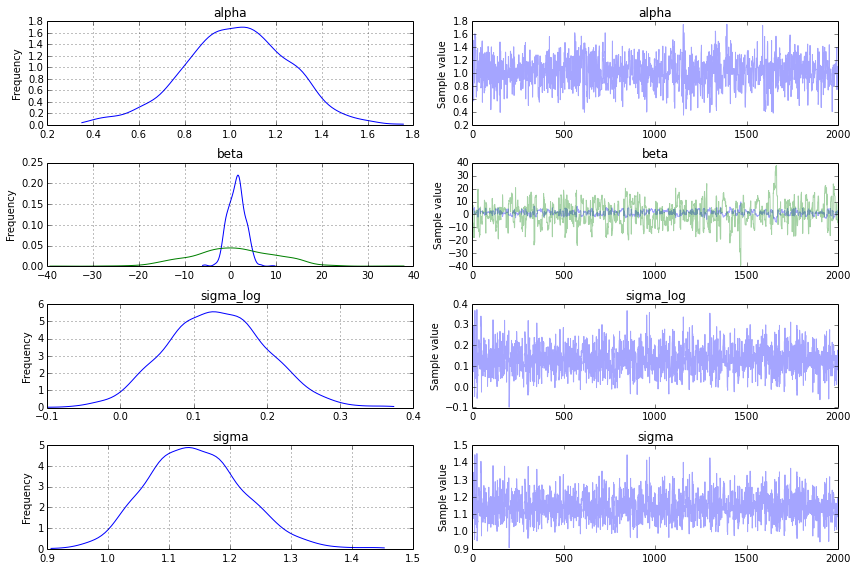

In [10]:
from pymc3 import traceplot

traceplot(trace);

The left column consists of a smoothed histogram (using kernel density estimation) of the marginal posteriors of each stochastic random variable while the right column contains the samples of the Markov chain plotted in sequential order. The `beta` variable, being vector-valued, produces two histograms and two sample traces, corresponding to both predictor coefficients.

In addition, the `summary` function provides a text-based output of common posterior statistics:

In [11]:
from pymc3 import summary

summary(trace)


alpha:
 
  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  1.027            0.227            0.007            [0.592, 1.487]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.552          0.878          1.031          1.185          1.456


beta:
 
  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  1.340            1.861            0.099            [-1.997, 4.799]
  0.838            9.188            0.488            [-16.926, 16.472]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  -1.994         0.027          1.413          2.540          4.805
  -16.534        -5.052         0.

##Case study 1: Stochastic volatility

We present a case study of stochastic volatility, time varying stock market volatility, to illustrate PyMC3's use in addressing a more realistic problem. The distribution of market returns is highly non-normal, which makes sampling the volatlities significantly more difficult. This example has 400+ parameters so using common sampling algorithms like Metropolis-Hastings would get bogged down, generating highly autocorrelated samples. Instead, we use NUTS, which is dramatically more efficient.

###The Model

Asset prices have time-varying volatility (variance of day over day `returns`). In some periods, returns are highly variable, while in others they are very stable. Stochastic volatility models address this with a latent volatility variable, which changes over time. The following model is similar to the one described in the NUTS paper (Hoffman 2014, p. 21).

$$\begin{aligned} 
  \sigma &\sim exp(50) \\
  \nu &\sim exp(.1) \\
  s_i &\sim \mathcal{N}(s_{i-1}, \sigma^{-2}) \\
  log(y_i) &\sim t(\nu, 0, exp(-2 s_i))
\end{aligned}$$

Here, $y$ is the daily return series which is modeled with a Student-t distribution with an unknown degrees of freedom parameter, and a scale parameter determined by a latent process $s$. The individual $s_i$ are the individual daily log volatilities in the latent log volatility process. 

###The Data

Our data consist of the last 400 daily returns of the S&P 500.

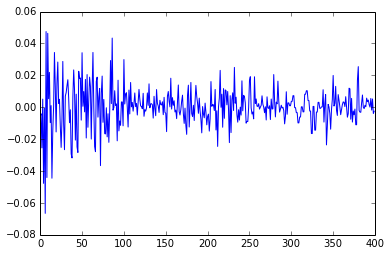

In [12]:
n = 400
returns = np.genfromtxt("data/SP500.csv")[-n:]
pl.plot(returns);

###Model Specification

As with the linear regession example, specifying the model in PyMC3 mirrors its statistical specification. This model employs several new distributions: the `Exponential` distribution for the $ \nu $ and $\sigma$ priors, the student-t (`T`) distribution for distribution of returns, and the `GaussianRandomWalk` for the prior for the latent volatilities.   

In PyMC3, variables with purely positive priors like `Exponential` are transformed with a log transform. This makes sampling more robust. Behind the scenes, a variable in the unconstrained space (named "variableName_log") is added to the model for sampling. In this model his happens behind the scenes for both the degrees of freedom, `nu`, and the scale parameter for the volatility process, `sigma`, since they both have exponential priors. Variables with priors that constrain them on two sides, like `Beta` or `Uniform`, are also transformed to be unconstrained but with a log odds transform. 

Although, unlike model specifiation in PyMC2, we do not typically provide starting points for variables at the model specification stage, we can also provide an initial value for any distribution (called a "test value") using the `testval` argument. This overrides the default test value for the distribution (usually the mean, median or mode of the distribution), and is most often useful if some values are illegal and we want to ensure we select a legal one. The test values for the distributions are also used as a starting point for sampling and optimization by default, though this is easily overriden. 

The vector of latent volatilities `s` is given a prior distribution by `GaussianRandomWalk`. As its name suggests GaussianRandomWalk is a vector valued distribution where the values of the vector form a random normal walk of length n, as specified by the `shape` argument. The scale of the innovations of the random walk, `sigma`, is specified in terms of the precision of the normally distributed innovations and can be a scalar or vector. 

In [14]:
from pymc3 import Exponential, T, exp, Deterministic
from pymc3.distributions.timeseries import GaussianRandomWalk

with Model() as sp500_model:
    
    nu = Exponential('nu', 1./10, testval=.1)
    
    sigma = Exponential('sigma', 1./.02, testval=.1)
    
    s = GaussianRandomWalk('s', sigma**-2, shape=n)
    
    volatility_process = Deterministic('volatility_process', exp(-2*s))
    
    r = T('r', nu, lam=1/volatility_process, observed=returns)

Notice that we transform the log volatility process `s` into the volatility process by `exp(-2*s)`. Here, `exp` is a Theano function, rather than the corresponding function in NumPy; Theano provides a large subset of the mathematical functions that NumPy does.

Also note that we have declared the `Model` name `sp500_model` in the first occurrence of the context manager, rather than splitting it into two lines, as we did for the first example.

###Fitting

Before we draw samples from the posterior, it is prudent to find a decent starting valuwa by finding a point of relatively high probability. For this model, the full *maximum a posteriori* (MAP) point over all variables is degenerate and has infinite density. But, if we fix `log_sigma` and `nu` it is no longer degenerate, so we find the MAP with respect only to the volatility process `s` keeping `log_sigma` and `nu` constant at their default values (remember that we set `testval=.1` for `sigma`). We use the Limited-memory BFGS (L-BFGS) optimizer, which is provided by the `scipy.optimize` package, as it is more efficient for high dimensional functions and we have 400 stochastic random variables (mostly from `s`).

To do the sampling, we do a short initial run to put us in a volume of high probability, then start again at the new starting point. `trace[-1]` gives us the last point in the sampling trace. NUTS will recalculate the scaling parameters based on the new point, and in this case it leads to faster sampling due to better scaling.

In [14]:
import scipy
with sp500_model:
    start = find_MAP(vars=[s], fmin=scipy.optimize.fmin_l_bfgs_b)
    
    step = NUTS(scaling=start)
    trace = sample(50, step, progressbar=False)

    # Start next run at the last sampled position.
    step = NUTS(scaling=trace[-1], gamma=.25)
    trace = sample(2000, step, start=trace[-1],progressbar=False, njobs=4)

We can check our samples by looking at the traceplot for `nu` and `sigma`.

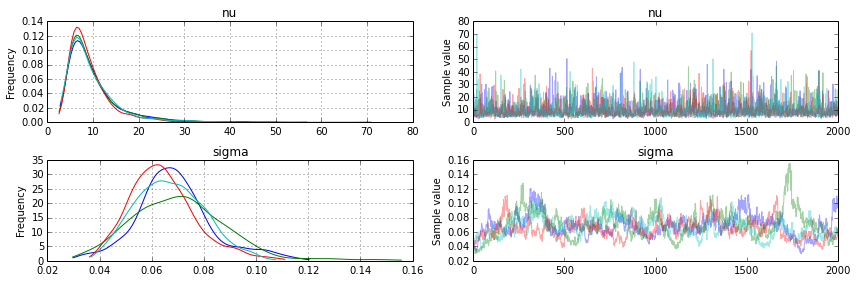

In [16]:
#figsize(12,6)
traceplot(trace, [nu, sigma]);

Finally we plot the distribution of volatility paths by plotting many of our sampled volatility paths on the same graph. Each is rendered partially transparent (via the `alpha` argument in Matplotlib's `plot` function) so the regions where many paths overlap are shaded more darkly.

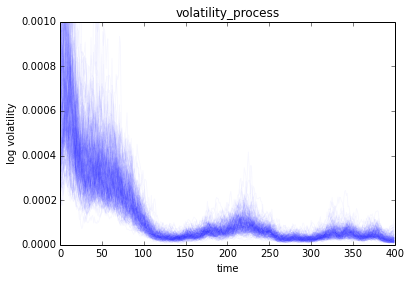

In [22]:
pl.title("volatility_process");
pl.plot(trace['volatility_process',::30].T,'b', alpha=.03);
pl.ylim(0, .001)
pl.xlabel('time');
pl.ylabel('log volatility');

## Case study 2: Coal mining disasters

Consider the following time series of recorded coal mining disasters in the UK from 1851 to 1962 (Jarrett, 1979). The number of disasters is thought to have been affected by changes in safety regulations during this period. Unfortunately, we also have pair of years with missing data, identified as missing by a NumPy MaskedArray using -999 as the marker value. 

Next we will build a model for this series and attempt to estimate when the change occured. At the same time, we will see how to handle missing data, use multiple samplers and sample from discrete random variables. 

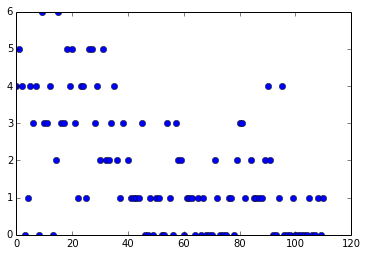

In [18]:
disaster_data = np.ma.masked_values([4, 5, 4, 0, 1, 4, 3, 4, 0, 6, 3, 3, 4, 0, 2, 6,
                            3, 3, 5, 4, 5, 3, 1, 4, 4, 1, 5, 5, 3, 4, 2, 5,
                            2, 2, 3, 4, 2, 1, 3, -999, 2, 1, 1, 1, 1, 3, 0, 0,
                            1, 0, 1, 1, 0, 0, 3, 1, 0, 3, 2, 2, 0, 1, 1, 1,
                            0, 1, 0, 1, 0, 0, 0, 2, 1, 0, 0, 0, 1, 1, 0, 2,
                            3, 3, 1, -999, 2, 1, 1, 1, 1, 2, 4, 2, 0, 0, 1, 4,
                            0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1], value=-999)

pl.plot(disaster_data, 'o', markersize=6);

Occurrences of disasters in the time series is thought to follow a Poisson process with a large rate parameter in the early part of the time series, and from one with a smaller rate in the later part. We are interested in locating the change point in the series, which perhaps is related to changes in mining safety regulations.

In our model, 

$$ 
\begin{aligned}  
  D_t &\sim \text{Pois}(r_t), r_t= \begin{cases} 
   l, & \text{if } t \lt s \\
   r, & \text{if } t \ge s 
   \end{cases} \\
  s &\sim \text{Unif}(t_l, t_h)\\         
  e &\sim \text{exp}(1)\\
  l &\sim \text{exp}(1)    
\end{aligned}
$$
 the parameters are defined as follows: 
   * $D_t$: The number of disasters in year $t$
   * $r_t$: The rate parameter of the Poisson distribution of disasters in year $t$.
   * $s$: The year in which the rate parameter changes (the switchpoint).
   * $e$: The rate parameter before the switchpoint $s$.
   * $l$: The rate parameter after the switchpoint $s$.
   * $t_l$, $t_h$: The lower and upper boundaries of year $t$.
   
This model is built much like our previous models. The major differences are the introduction of discrete variables with the Poisson and discrete-uniform priors and the novel form of the deterministic random variable `rate`.

In [19]:
from pymc3 import DiscreteUniform, Poisson, switch

year = np.arange(len(disaster_data))

with Model() as disaster_model:

    switchpoint = DiscreteUniform('switchpoint', lower=0, upper=len(year))

    # Priors for pre- and post-switch mean number of disasters
    early_mean = Exponential('early_mean', lam=1.)
    late_mean = Exponential('late_mean', lam=1.)

    # Allocate appropriate Poisson rates to years before and after current
    rate = switch(switchpoint >= year, early_mean, late_mean)

    disasters = Poisson('disasters', rate, observed=disaster_data)

The logic for the rate random variable,
```python
rate = switch(switchpoint >= year, early_mean, late_mean)
```
is implemented using `switch`, a Theano function that works like an if statement. It uses the first argument to switch between the next two arguments.

Missing values are handled transparently by passing a `MaskedArray` or a `pandas.DataFrame` with NaN values to the `observed` argument when creating an observed stochastic random variable. Behind the scenes, another random variable, `disasters.missing_values` is created to model the missing values. All we need to do to handle the missing values is ensure we sample this random variable as well.

Unfortunately because they are discrete variables and thus have no meaningful gradient, we cannot use NUTS for sampling `switchpoint` or the missing disaster observations. Instead, we will sample using a `Metroplis` step method, which implements adaptive Metropolis-Hastings, because it is designed to handle discrete values.

We sample with both samplers at once by passing them to the `sample` function in a list. Each new sample is generated by first applying `step1` then `step2`.

In [20]:
from pymc3 import Metropolis 

with disaster_model:
    step1 = NUTS([early_mean, late_mean])
    
    # Use Metropolis for switchpoint, and missing values since it accomodates discrete variables
    step2 = Metropolis([switchpoint, disasters.missing_values[0]] )

    trace = sample(10000, step=[step1, step2])

 [-----------------100%-----------------] 10000 of 10000 complete in 15.5 sec

In the trace plot below we can see that there's about a 10 year span that's plausible for a significant change in safety, but a 5 year span that contains most of the probability mass. The distribution is jagged because of the jumpy relationship beween the year switchpoint and the likelihood  and not due to sampling error.

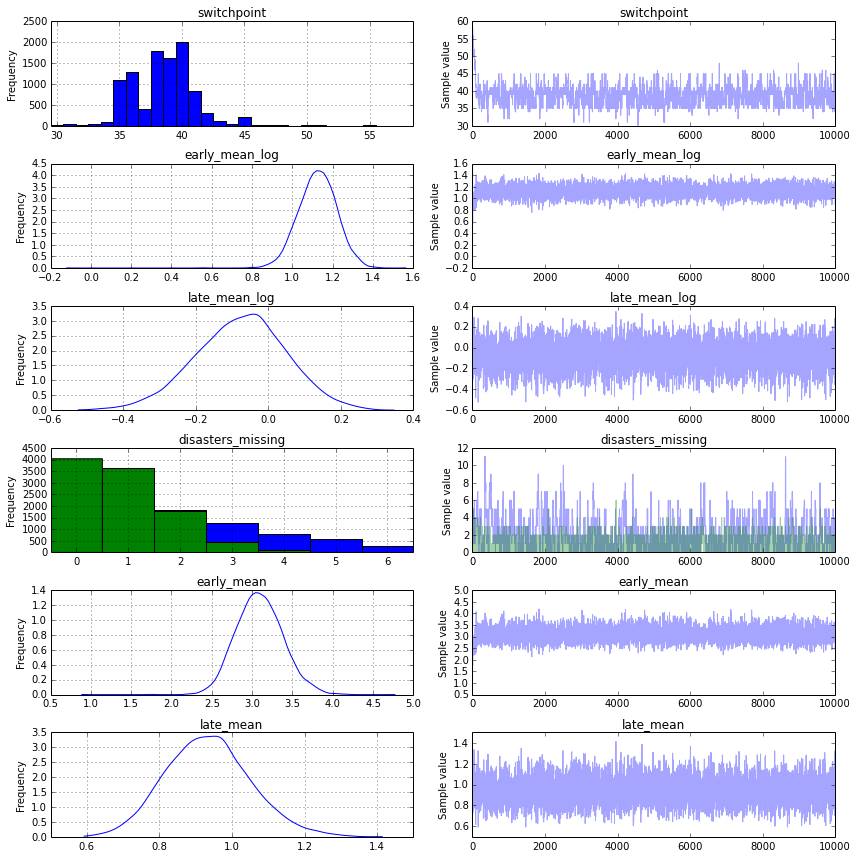

In [21]:
traceplot(trace);

## Arbitrary deterministics

Due to its reliance on Theano, PyMC3 provides many mathematical functions and operators for transforming random variables into new random variables. However, the library of functions in Theano is not exhaustive, therefore Theano and PyMC3 provide functionality for creating arbitrary Theano functions in pure Python, and including these functions in PyMC models. This is supported with the `as_op` function decorator.

Theano needs to know the types of the inputs and outputs of a function, which are specified for `as_op` by `itypes` for inputs and `otypes` for outputs. The Theano documentation includes [an overview of the available types](http://deeplearning.net/software/theano/library/tensor/basic.html#all-fully-typed-constructors).

In [22]:
import theano.tensor as T 
from theano.compile.ops import as_op

@as_op(itypes=[T.lscalar], otypes=[T.lscalar])
def crazy_modulo3(value):
    if value > 0: 
        return value % 3
    else :
        return (-value + 1) % 3
    
with Model() as model_deterministic:
    a = Poisson('a', 1)
    b = crazy_modulo3(a)

An important drawback of this approach is that it is not possible for `theano` to inspect these functions in order to compute the gradient required for the Hamiltonian-based samplers. Therefore, it is not possible to use the HMC or NUTS samplers for a model that uses such an operator. However, it is possible to add a gradient if we inherit from `theano.Op` instead of using `as_op`. The PyMC example set includes [a more elaborate example of the usage of `as_op`](https://github.com/pymc-devs/pymc/blob/master/pymc/examples/disaster_model_arbitrary_deterministic.py).

## Arbitrary distributions

Similarly, the library of statistical distributions in PyMC3 is not exhaustive, but PyMC allows for the creation of user-defined functions for an arbitrary probability distribution. For simple statistical distributions, the `DensityDist` function takes as an argument any function that calculates a log-probability $log(p(x))$. This function may employ other random variables in its calculation. Here is an example inspired by a blog post by Jake Vanderplas on which priors to use for a linear regression (Vanderplas, 2014). 

```python
import theano.tensor as T
from pymc3 import DensityDist, Uniform

with Model() as model:
    alpha = Uniform('intercept', -100, 100)
    
    # Create custom densities
    beta = DensityDist('beta', lambda value: -1.5 * T.log(1 + value**2), testval=0)
    eps = DensityDist('eps', lambda value: -T.log(T.abs_(value)), testval=1)
    
    # Create likelihood
    like = Normal('y_est', mu=alpha + beta * X, sd=eps, observed=Y)
```

For more complex distributions, one can create a subclass of `Continuous` or `Discrete` and provide the custom `logp` function, as required. This is how the built-in distributions in PyMC are specified. As an example, fields like psychology and astrophysics have complex likelihood functions for a particular process that may require numerical approximation. In these cases, it is impossible to write the function in terms of predefined theano operators and we must use a custom theano operator using `as_op` or inheriting from `theano.Op`. 

Implementing the `beta` variable above as a `Continuous` subclass is shown below, along with a sub-function using the `as_op` decorator, though this is not strictly necessary.

In [23]:
from pymc3.distributions import Continuous

class Beta(Continuous):
    def __init__(self, mu, *args, **kwargs):
        super(Beta, self).__init__(*args, **kwargs)
        self.mu = mu
        self.mode = mu

    def logp(self, value):
        mu = self.mu
        return beta_logp(value - mu)
    
@as_op(itypes=[T.dscalar], otypes=[T.dscalar])
def beta_logp(value):
    return -1.5 * np.log(1 + (value)**2)


with Model() as model:
    beta = Beta('slope', mu=0, testval=0)

# Generalized Linear Models

Generalized Linear Models (GLMs) are a class of flexible models that are widely used to estimate regression relationships between a single outcome variable and one or multiple predictors. Because these models are so common, `PyMC3` offers a `glm` submodule that allows flexible creation of various GLMs with an intuitive `R`-like syntax that is implemented via the `patsy` module.

The `glm` submodule requires data to be included as a `pandas` `DataFrame`. Hence, for our linear regression example:

In [24]:
# Convert X and Y to a pandas DataFrame
import pandas 
df = pandas.DataFrame({'x1': X1, 'x2': X2, 'y': Y})

The model can then be very concisely specified in one line of code.

In [25]:
from pymc3.glm import glm

with Model() as model_glm:
    glm('y ~ x1 + x2', df)

The error distribution, if not specified via the `family` argument, is assumed to be normal. In the case of logistic regression, this can be modified by passing in a `Binomial` family object.

In [26]:
from pymc3.glm.families import Binomial

df_logistic = pandas.DataFrame({'x1': X1, 'x2': X2, 'y': Y > 0})

with Model() as model_glm_logistic:
    glm('y ~ x1 + x2', df_logistic, family=Binomial())

## Backends

`PyMC3` has support for different ways to store samples during and after sampling, called backends, including in-memory (default), text file, and SQLite. These can be found in `pymc.backends`:

By default, an in-memory `ndarray` is used but if the samples would get too large to be held in memory we could use the `sqlite` backend:

In [27]:
from pymc3.backends import SQLite

with model_glm_logistic:
    backend = SQLite('trace.sqlite')
    trace = sample(5000, Metropolis(), trace=backend)

 [-----------------100%-----------------] 5000 of 5000 complete in 3.1 sec

In [28]:
summary(trace, vars=['x1', 'x2'])


x1:
 
  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  3.154            4.397            0.430            [-3.500, 11.395]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  -3.316         -0.528         2.405          6.702          11.905


x2:
 
  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  -15.684          22.018           2.149            [-56.366, 19.371]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  -60.666        -33.768        -11.679        2.311          17.021



The stored trace can then later be loaded using the `load` command:

In [35]:
from pymc3.backends.sqlite import load

with basic_model:
    trace_loaded = load('trace.sqlite')

More information about `backends` can be found in the docstring of `pymc.backends`.

## References

Patil, A., D. Huard and C.J. Fonnesbeck. (2010) PyMC: Bayesian Stochastic Modelling in Python. Journal of Statistical Software, 35(4), pp. 1-81

Bastien, F., Lamblin, P., Pascanu, R., Bergstra, J., Goodfellow, I., Bergeron, A., Bouchard, N., Warde-Farley, D., and Bengio, Y. (2012) “Theano: new features and speed improvements”. NIPS 2012 deep learning workshop.

Bergstra, J., Breuleux, O., Bastien, F., Lamblin, P., Pascanu, R., Desjardins, G., Turian, J., Warde-Farley, D., and Bengio, Y. (2010) “Theano: A CPU and GPU Math Expression Compiler”. Proceedings of the Python for Scientific Computing Conference (SciPy) 2010. June 30 - July 3, Austin, TX

Lunn, D.J., Thomas, A., Best, N., and Spiegelhalter, D. (2000) WinBUGS -- a Bayesian modelling framework: concepts, structure, and extensibility. Statistics and Computing, 10:325--337.

Neal, R.M. Slice sampling. Annals of Statistics. (2003). doi:10.2307/3448413.

van Rossum, G. The Python Library Reference Release 2.6.5., (2010). URL http://docs.python.org/library/.

Duane, S., Kennedy, A. D., Pendleton, B. J., and Roweth, D. (1987) “Hybrid Monte Carlo”, Physics Letters, vol. 195, pp. 216-222.

Stan Development Team. (2014). Stan: A C++ Library for Probability and Sampling, Version 2.5.0.   http://mc-stan.org. 

Gamerman, D. Markov Chain Monte Carlo: statistical simulation for Bayesian inference. Chapman and Hall, 1997.

Hoffman, M. D., & Gelman, A. (2014). The No-U-Turn Sampler: Adaptively Setting Path Lengths in Hamiltonian Monte Carlo. The Journal of Machine Learning Research, 30.

Vanderplas, Jake. "Frequentism and Bayesianism IV: How to be a Bayesian in Python." Pythonic Perambulations. N.p., 14 Jun 2014. Web. 27 May. 2015. <https://jakevdp.github.io/blog/2014/06/14/frequentism-and-bayesianism-4-bayesian-in-python/>.

R.G. Jarrett. A note on the intervals between coal mining disasters. Biometrika, 66:191–193, 1979.
